In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv
/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv


In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns #Data showing
import string
import nltk


In [3]:
#Read train and test data
train = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/train.csv')
test = pd.read_csv('/kaggle/input/twitter-sentiment-analysis-hatred-speech/test.csv')

print('-'*40)
print(f'Some data from train set')
print(train.head())

#tweet column needs to be cleaned

#1. Removing twitter handles
combi = train.append(test,ignore_index=True)

def remove_pattern(input_txt,pattern):
    r = re.findall(pattern,input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

#numpy vectorize function take input a function and give its vector form which is numpy aware
combi['tidy_tweet'] = np.vectorize(remove_pattern)(combi['tweet'],"@[\w]*")

#2. Removing punctuations, numbers and special char
combi['tidy_tweet'] = combi['tidy_tweet'].str.replace("[^a-zA-Z#]"," ")


#3. removing short words
#Apply method from pandas row by row processing

combi['tidy_tweet'] = combi['tidy_tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 3]))

#4&5. Tokenization & Stemming we can do it with spacy as well

tokenized_tweet = combi['tidy_tweet'].apply(lambda x:x.split())
from nltk.stem.porter import PorterStemmer
stemmer = PorterStemmer()
tokenized_tweet = tokenized_tweet.apply(lambda x:[stemmer.stem(i) for i in x])
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i] = ' '.join(tokenized_tweet[i])
combi['tidy_tweet'] = tokenized_tweet


----------------------------------------
Some data from train set
   id  label                                              tweet
0   1      0   @user when a father is dysfunctional and is s...
1   2      0  @user @user thanks for #lyft credit i can't us...
2   3      0                                bihday your majesty
3   4      0  #model   i love u take with u all the time in ...
4   5      0             factsguide: society now    #motivation


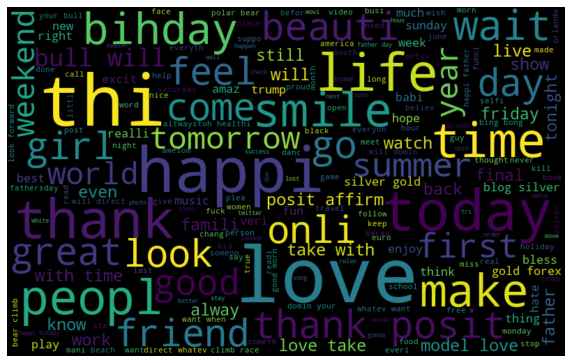

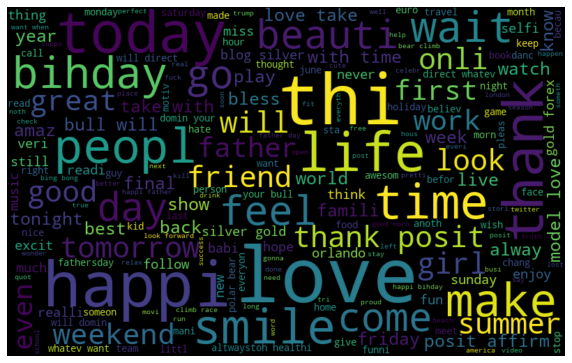

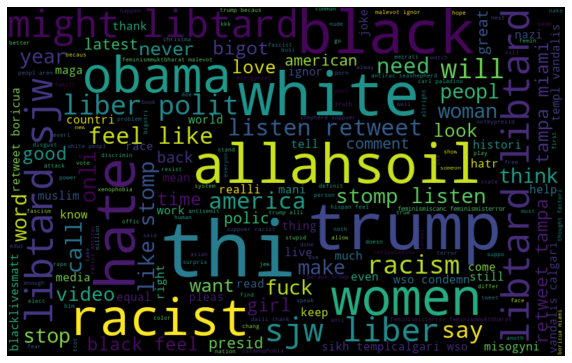

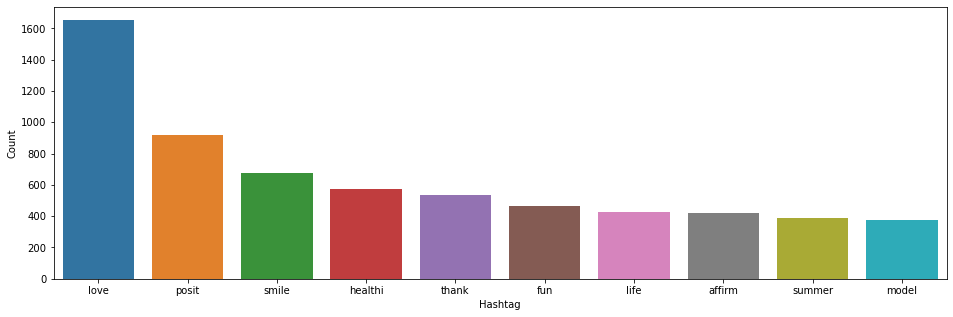

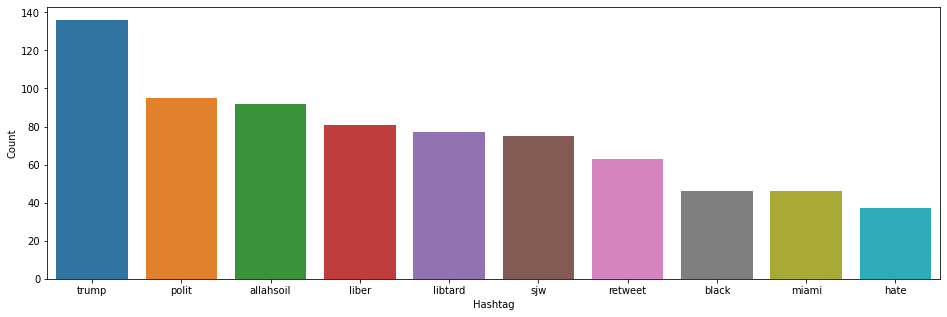

In [4]:
#1. Wordcloud to understand most frequent words
#Converting all columns into single string

all_words = ' '.join([text for text in combi['tidy_tweet']])
from wordcloud import WordCloud

word_cloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

normal_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 0]])
word_cloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(normal_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()

racist_sexist_words = ' '.join([text for text in combi['tidy_tweet'][combi['label'] == 1]])
word_cloud = WordCloud(width=800,height=500,random_state=21,max_font_size=110).generate(racist_sexist_words)
plt.figure(figsize=(10,7))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.show()


def hashtag_extract(x):
    hashtags = []
    for i in x:
        ht = re.findall(r"#(\w+)",i)
        hashtags.append(ht)

    return hashtags

HT_regular = hashtag_extract(combi['tidy_tweet'][combi['label'] == 0])
HT_negative = hashtag_extract(combi['tidy_tweet'][combi['label'] == 1])

#Question -> How this is working
HT_regular = sum(HT_regular,[])
HT_negative = sum(HT_negative,[])

#Non racist/sexist Comments
a = nltk.FreqDist(HT_regular)
d = pd.DataFrame({'Hashtag': list(a.keys()),
                  'Count': list(a.values())})
d = d.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=d, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

#Racist/Sexist Comments
b = nltk.FreqDist(HT_negative)
e = pd.DataFrame({'Hashtag': list(b.keys()), 'Count': list(b.values())})
e = e.nlargest(columns="Count", n = 10)
e = e.nlargest(columns="Count", n = 10)
plt.figure(figsize=(16,5))
ax = sns.barplot(data=e, x= "Hashtag", y = "Count")
ax.set(ylabel = 'Count')
plt.show()

#************************* STORY GEBERATION AND VISUALISATION ***************************


In [5]:
#************************* EXTRACTING FEATURES ******************************************
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.9,min_df=2,max_features=1000,stop_words='english')
bow = bow_vectorizer.fit_transform(combi['tidy_tweet'])

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(combi['tidy_tweet'])


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

train_bow = bow[:31962,:]
test_bow = bow[31962:,:]

#Split data into train and validation set
xtrain_bow,xvalid_bow,ytrain,yvalid = train_test_split(train_bow,train['label'],random_state=42,test_size=.3)

lreg = LogisticRegression()
lreg.fit(xtrain_bow,ytrain)

prediction = lreg.predict_proba(xvalid_bow)
prediction_int = prediction[:,1] >= .24

prediction_int = prediction_int.astype(np.int)
print(f1_score(yvalid,prediction_int))

train_tfidf = tfidf[:31962,:]
test_tfidf = tfidf[31962:,:]

xtrain_tfidf = train_tfidf[ytrain.index]
xvalid_tfidf = train_tfidf[yvalid.index]

lreg.fit(xtrain_tfidf, ytrain)
prediction = lreg.predict_proba(xvalid_tfidf)
prediction_int = prediction[:,1] >= 0.3
prediction_int = prediction_int.astype(np.int)
print(f1_score(yvalid, prediction_int))

test_pred = lreg.predict_proba(test_bow)
test_pred_int = test_pred[:,1] >= 0.24
test_pred_int = test_pred_int.astype(np.int)
test['label'] = test_pred_int
submission = test[['id','label']]
submission.to_csv('sub_lreg_bow.csv', index=False)


0.5386381025248661
0.5451327433628319


In [6]:
import spacy
nlp = spacy.load('en_core_web_lg')
with nlp.disable_pipes():
    doc_vectors = np.array([nlp(text).vector for text in combi['tidy_tweet']])

In [25]:
train_wrdtovec = doc_vectors[:31962,:]
test_wrdtovec = doc_vectors[31962:,:]

xtrain_wrdtovec = train_wrdtovec[ytrain.index]
xvalid_wrdtovec = train_wrdtovec[yvalid.index]

lreg = LogisticRegression(max_iter = 9000)
lreg.fit(xtrain_wrdtovec, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
prediction = lreg.predict_proba(xvalid_wrdtovec)
prediction_int = prediction[:,1] >= 0.2
prediction_int = prediction_int.astype(np.int)
print(f1_score(yvalid, prediction_int))

0.4996539792387544


In [10]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
doc_vectors_scaled = min_max_scaler.fit_transform(doc_vectors)

In [16]:
train_wrdtovec = doc_vectors_scaled[:31962,:]
test_wrdtovec = doc_vectors_scaled[31962:,:]

xtrain_wrdtovec = train_wrdtovec[ytrain.index]
xvalid_wrdtovec = train_wrdtovec[yvalid.index]

lreg = LogisticRegression(max_iter = 9000)
lreg.fit(xtrain_wrdtovec, ytrain)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=9000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [24]:
prediction = lreg.predict_proba(xvalid_wrdtovec)
prediction_int = prediction[:,1] >= 0.15
prediction_int = prediction_int.astype(np.int)
print(f1_score(yvalid, prediction_int))

0.5003035822707953
